In [1]:
# loading packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import geopandas as gpd
import matplotlib.patches as mpatches
import helper

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import matplotlib.style as style
plt.style.use("markerr.mplstyle")

#### prepping for mapping

In [2]:
# source: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.2018.html
zips = gpd.read_file('cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp')
zips['GEOID10'] = zips['GEOID10'].astype(int)

# lists of relevent zipcodes
target_zips = pd.read_csv('target.csv', index_col = 0)
houston_zips_list = list(target_zips[target_zips['City']=='Houston']['zip_code'].unique())
paso_zips_list = list(target_zips[target_zips['City']=='El Paso']['zip_code'].unique())
san_zips_list = list(target_zips[target_zips['City']=='San Antonio']['zip_code'].unique())
austin_zips_list = list(target_zips[target_zips['City']=='Austin']['zip_code'].unique())
dallas_zips_list = list(target_zips[target_zips['City']=='Dallas-Fort Worth']['zip_code'].unique())
# limitting the zips to just inside the region around TX 
zips = zips[zips['AFFGEOID10'].str[0:10] == '8600000US7'].reset_index()

# limiting to the inidvidual regions of interest
houston_zips = zips.loc[zips.loc[:,'GEOID10'].isin(houston_zips_list),:]
paso_zips = zips.loc[zips.loc[:,'GEOID10'].isin(paso_zips_list),:]
san_zips = zips.loc[zips.loc[:,'GEOID10'].isin(san_zips_list),:]
austin_zips = zips.loc[zips.loc[:,'GEOID10'].isin(austin_zips_list),:]
dallas_zips = zips.loc[zips.loc[:,'GEOID10'].isin(dallas_zips_list),:]

# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}


#### Loading and processing data to put into model. And Construct model.

In [3]:
# load data
texas_data = pd.read_csv('merged_texas_data.csv', index_col = 0,
                   parse_dates = ['Time']
                  )

acs_data = pd.read_csv('merged_acs_data.csv', index_col = 0,
                      parse_dates = ['Time'])

zri = pd.read_csv('long_interpolated_target.csv', index_col = 0,
                   parse_dates=['Time']
                  )

# Merge and lag data to be ready to forecast a year in the future
merged_df = helper.zri_data_pipeline(zri, texas_data, acs_data)

# Split dataframe into train, test, and forecast,
train, test, forecast = helper.train_test_forecast_split(
    merged_df,
    train_date = datetime.datetime(2020,7,2), 
    forecast_date = datetime.datetime(2021,7,2)
)

# define features to be put into the model and target variable.

X_vals = [
    'zori_ssa_12_month_shift',
    'zori_ssa_1_diff_lag_12',
    'zori_ssa_6_diff_lag_12',
    'total_sales_tax_12_month_shift',
    'housing_units_over_50_units_36_month_shift',
    'housing_units_built_1960_to_1969_36_month_shift',
    'black_pop_48_month_shift',
    'zori_ssa_12_diff_lag_12_per',
    'children_annual_pct_change_48_month_shift',
    'female_40_to_44_annual_pct_change_36_month_shift',
    'housing_units_10_to_19_units_annual_pct_change_36_month_shift',
    'sales_tax_rate_annual_pct_change_12_month_shift',
    'female_female_households_48_month_shift',
    'women_with_associate_degree_annual_pct_change_36_month_shift',
    'average_household_size_owners_annual_pct_change_36_month_shift',
    'units_paying_cash_rent_annual_pct_change_36_month_shift',
    'quintile_1_upper_limit_annual_pct_change_36_month_shift',
    'Gross Value Natural Gas Production_13_month_shift',
    'women_with_doctoral_degree_annual_pct_change_36_month_shift',
    'total_sales_tax_annual_pct_change_12_month_shift',
    'housing_units_built_1940_to_1949_36_month_shift',
    'housing_units_built_1980_to_1989_annual_pct_change_36_month_shift',
    'female_35_to_39_annual_pct_change_36_month_shift',
    'bicycle_population_36_month_shift',
    'housing_units_20_to_49_units_annual_pct_change_36_month_shift',
    'taxpayer_count_12_month_shift',
    'housing_units_5_to_9_units_36_month_shift',
    'high_school_diploma_annual_pct_change_48_month_shift',
    'driving_alone_population_annual_pct_change_36_month_shift',
    'taxpayer_is_ratio_12_month_shift',
    'motorcycle_population_36_month_shift',
    'housing_units_single_family_attached_annual_pct_change_36_month_shift',
    'white_pop_annual_pct_change_48_month_shift',
    'taxpayer_cl_ratio_annual_pct_change_12_month_shift',
    'taxpayer_is_ratio_annual_pct_change_12_month_shift',
    'housing_units_built_1940_to_1949_annual_pct_change_36_month_shift',
    'black_pop_annual_pct_change_48_month_shift',
    'Gross Value Natural Gas Production_annual_pct_change_12_month_shift',
    'housing_units_single_family_attached_owned_36_month_shift',
    'single_women_annual_pct_change_36_month_shift',
    'housing_units_built_1930_to_1939_36_month_shift',
    'housing_units_built_1930_to_1939_annual_pct_change_36_month_shift',
    'female_25_to_29_annual_pct_change_36_month_shift',    
    'tx_net_approve_12_month_shift'
    ]
y_val = 'zori_ssa'

# Shrink data to features to be put into the model
# and scale data to prepare it to be put into the model
# train first
scaler = StandardScaler(with_mean=False)
X = train[X_vals]
X = scaler.fit_transform(X)
y = train[y_val]
# test all
X_test = test[X_vals]
X_test = scaler.transform(X_test)
y_test = test[y_val]
# forecasted values
X_forecast = forecast[X_vals]
X_forecast = scaler.transform(X_forecast)

# construct model
clf = helper.lasso_gridCV_fit(X, y)

Performing Grid Search with alphas of: [0.1, 0.2, 0.3, 0.6, 1]
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best alpha 0.1


####  Feeding forecast values into model

In [4]:
y_pred_fore = clf.predict(X_forecast)
forecast.loc[:,'pred'] = y_pred_fore

#### Construct timeline of zori and what prediciton status they are.

In [5]:
# find predicted and actual annual percent rent growth
y_pred_test = clf.predict(X_test)
test.loc[:,'pred'] = y_pred_test
test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_pred_test

test['pred_12_month_growth'] = test['pred'] - test['zori_ssa_12_month_shift']
test['actual_12_month_growth'] = test['zori_ssa'] - test['zori_ssa_12_month_shift']

test['pred_12_month_growth_per'] = test['pred_12_month_growth']/test['zori_ssa_12_month_shift']
test['actual_12_month_growth_per'] = test['actual_12_month_growth']/test['zori_ssa_12_month_shift']
test['pred_difference_per'] = test['pred_difference']/test['zori_ssa_12_month_shift']

# average that growth across all 12 months for each zipcode
pred_growth = test.groupby('zip_code').agg(
    mean_pred_growth=('pred_12_month_growth_per', 'mean'),
    std_pred_growth=('pred_12_month_growth_per', 'std'),
    mean_act_growth=('actual_12_month_growth_per', 'mean'),
    std_act_growth=('actual_12_month_growth_per', 'std'),
    mean_naive_growth=('zori_ssa_12_diff_lag_12_per', 'mean'),
    std_naive_growth=('zori_ssa_12_diff_lag_12_per', 'std'),    
).reset_index()

# make list of zip codes the model thinks will grow an average of 4%
model_rec_zips = pred_growth[pred_growth['mean_pred_growth']>.04].zip_code.to_list()
# make a list of zip codes that averaged a 4% growth in the past year.
naive_rec_zips = pred_growth[pred_growth['mean_naive_growth']>.04].zip_code.to_list()

In [6]:
# define each zipcode zipcode based on if model and/or naive approach recommends the zipcode
pred_growth.loc[:,'invest_rec_5_per'] = 0
pred_growth.loc[pred_growth['zip_code'].isin(model_rec_zips),'invest_rec_5_per'] = 3
pred_growth.loc[pred_growth['zip_code'].isin(naive_rec_zips),'invest_rec_5_per'] = 1
pred_growth.loc[(pred_growth['zip_code'].isin(naive_rec_zips) &
          pred_growth['zip_code'].isin(model_rec_zips))
          ,'invest_rec_5_per'] = 2

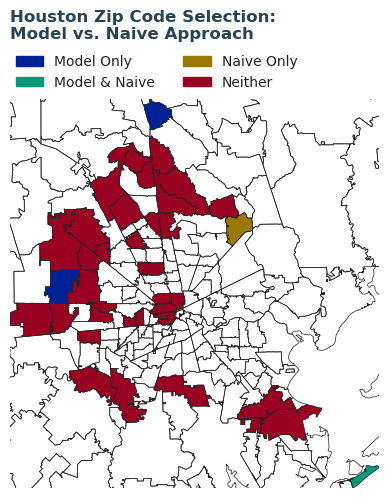

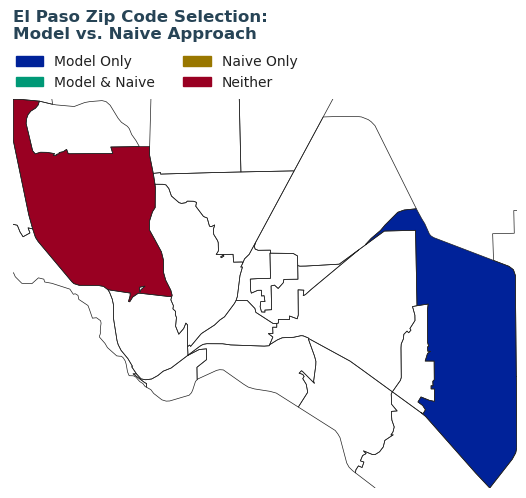

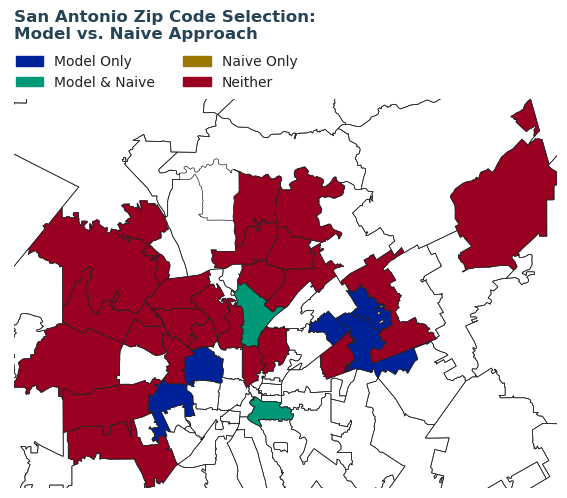

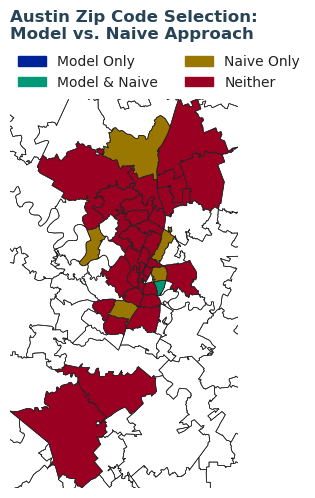

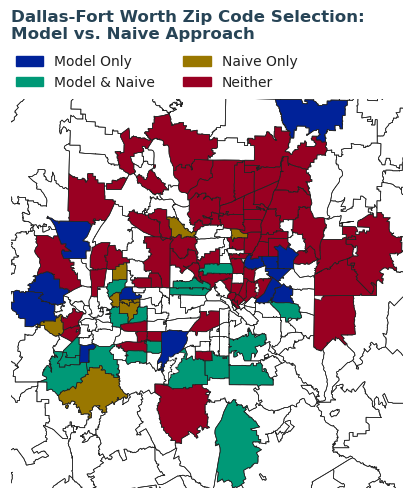

In [7]:
four_colors = ['#990022','#997700','#009977','#002299']
zips_code = [0,1,2,3]
color_mapping = dict(zip(zips_code,four_colors))

map_ = pred_growth
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():
    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
#                      column = graph_df["invest_rec_5_per"], 
                  color=graph_df["invest_rec_5_per"].map(color_mapping),
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro +' Zip Code Selection:\nModel vs. Naive Approach\n\n\n')
    # # legend
    acutal_patch = mpatches.Patch(color=four_colors[3], 
                               label='Model Only')
    lasso_patch = mpatches.Patch(color=four_colors[2], 
                               label='Model & Naive')
    rf_patch = mpatches.Patch(color=four_colors[1], 
                               label='Naive Only')
    xg_patch = mpatches.Patch(color=four_colors[0], 
                               label='Neither')
    plt.legend(handles=[acutal_patch,lasso_patch,rf_patch,xg_patch],
               loc='center left', 
               bbox_to_anchor=(-0.02, 1.07),frameon=False,ncol=2,
                    title = '')
    plt.show()

### Model Errors

#### Model errors by recommendation type

<ipython-input-8-cb2e66a7d6ba>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1%}'.format(x) for x in vals])


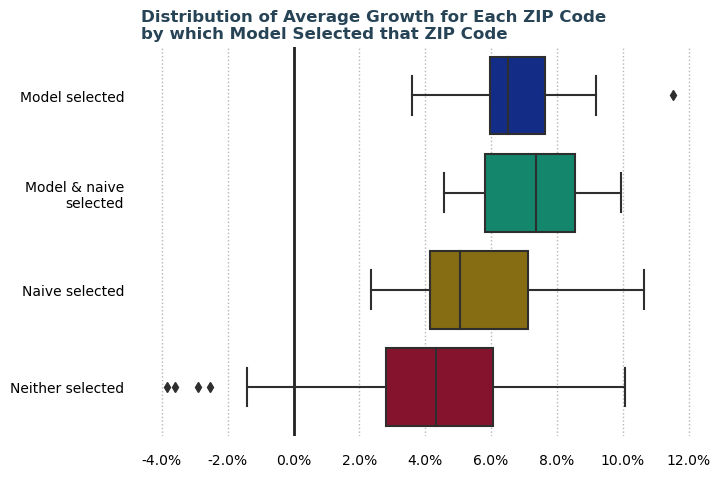

In [8]:
graph_df = pred_growth
blacks = ['#212121']
fig, ax = plt.subplots()
g = sns.boxplot(data = graph_df, y = 'invest_rec_5_per',
                x = 'mean_act_growth', palette = four_colors[::-1],
                orient = 'h',ax = ax, order = [3,2,1,0]
                )

# remove x axis grid lines that were cluttering the graph
ax.grid(b = None, axis = 'y')

# # set labels
g.set_yticklabels(labels = [
    'Model selected', 'Model & naive\nselected', 
    'Naive selected', 'Neither selected'
])
# g.set_xticklabels(labels = ['','-5%','0%','5%','10%','15%'])




# set title
g.set(xlabel='', ylabel='',
      title='Distribution of Average Growth for Each ZIP Code'+
      ' \nby which Model Selected that ZIP Code')

# # adding a vertical line at 0 percent growth
# blacks = ['#212121']
plt.axvline(0, color = blacks[0], zorder = .7, linewidth = 2)

# add percent x tick labels
vals = ax.get_xticks()
ax.set_xticklabels(['{:.1%}'.format(x) for x in vals])

# remove x axis grid lines that were cluttering the graph
ax.grid(b = None, axis = 'y')

plt.show()

#### Model errors zip code

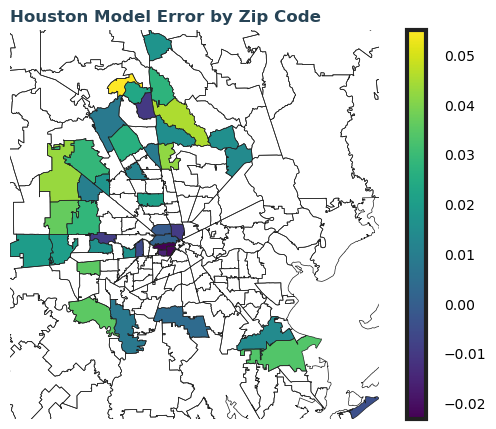

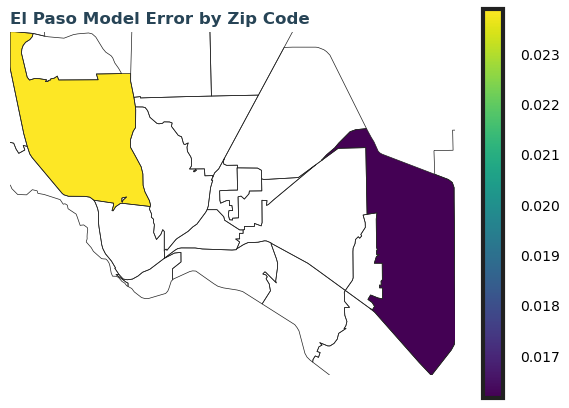

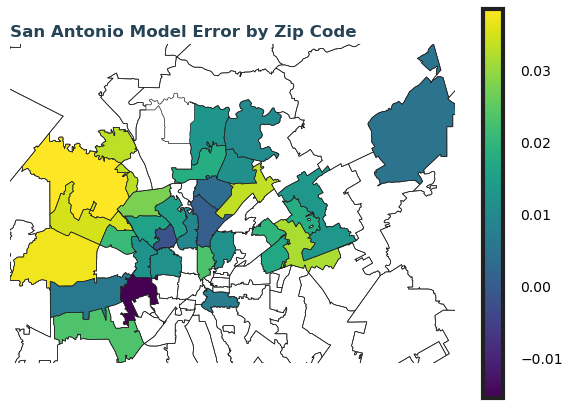

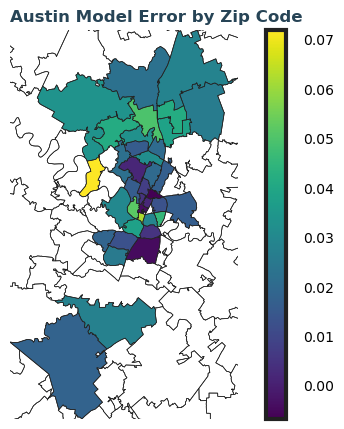

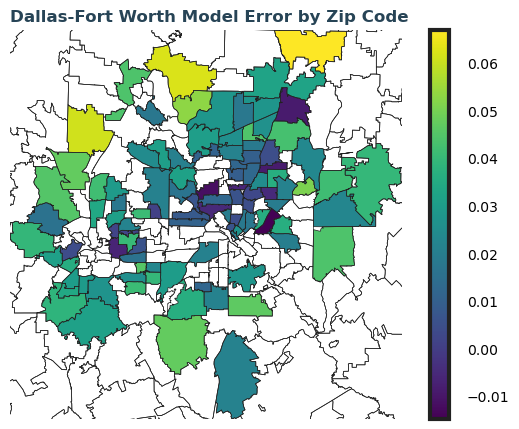

In [9]:
four_colors = ['#990022','#997700','#009977','#002299']
pred_errors = test.groupby('zip_code').agg({'pred_difference_per':'mean'}).reset_index()
map_ = pred_errors
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():
    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["pred_difference_per"], 
#                   color=graph_df["invest_rec_5_per"].map(color_mapping),
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro +' Model Error by Zip Code')
    plt.show()

## forecasted recommendations

In [10]:
forecast['pred_12_month_growth'] = forecast['pred'] - forecast['zori_ssa_12_month_shift']
forecast['pred_12_month_growth_per'] = forecast['pred_12_month_growth']/forecast['zori_ssa_12_month_shift']

fore_pred_growth = test.groupby('zip_code').agg(
    mean_pred_growth=('pred_12_month_growth_per', 'mean'),
    std_pred_growth=('pred_12_month_growth_per', 'std'),
    mean_naive_growth=('zori_ssa_12_diff_lag_12_per', 'mean'),
    std_naive_growth=('zori_ssa_12_diff_lag_12_per', 'std'),    
).reset_index()
## place to change the given risk thresh hold
fore_five_per_zips = fore_pred_growth[((fore_pred_growth['mean_pred_growth']>.04) &
                             (fore_pred_growth['std_pred_growth']<1))
                           ].zip_code.to_list()
fore_naive_five_per_zips = fore_pred_growth[((fore_pred_growth['mean_naive_growth']>.04) &
                             (fore_pred_growth['std_naive_growth']<1))
                           ].zip_code.to_list()

In [11]:
forecast.loc[:,'invest_rec_5_per'] = 0
forecast.loc[forecast['zip_code'].isin(fore_five_per_zips),'invest_rec_5_per'] = 3
forecast.loc[forecast['zip_code'].isin(fore_naive_five_per_zips),'invest_rec_5_per'] = 1
forecast.loc[(forecast['zip_code'].isin(fore_naive_five_per_zips) &
          forecast['zip_code'].isin(fore_five_per_zips))
          ,'invest_rec_5_per'] = 2


fore_pred_growth.loc[:,'invest_rec_5_per'] = 0
fore_pred_growth.loc[fore_pred_growth['zip_code'].isin(fore_five_per_zips),'invest_rec_5_per'] = 3
fore_pred_growth.loc[fore_pred_growth['zip_code'].isin(fore_naive_five_per_zips),'invest_rec_5_per'] = 1
fore_pred_growth.loc[(fore_pred_growth['zip_code'].isin(fore_naive_five_per_zips) &
          fore_pred_growth['zip_code'].isin(fore_five_per_zips))
          ,'invest_rec_5_per'] = 2

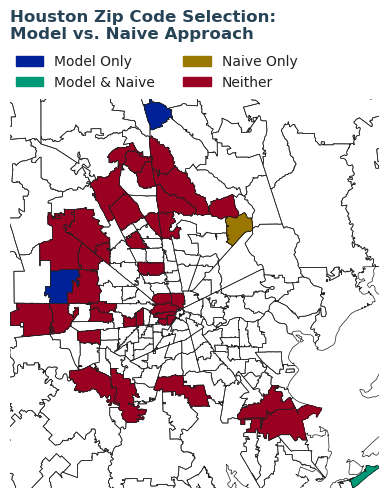

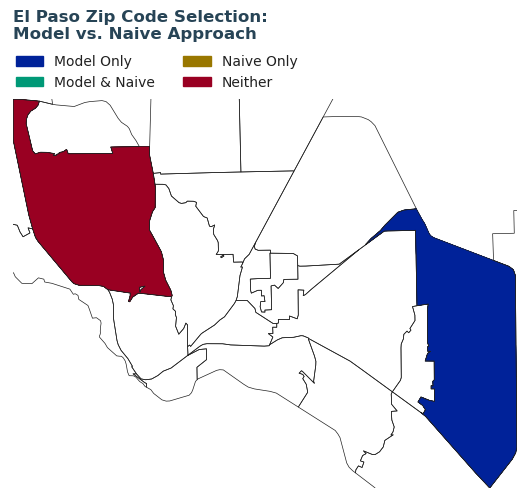

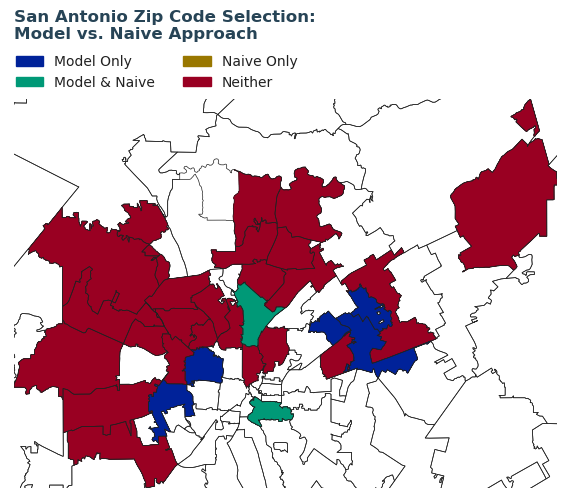

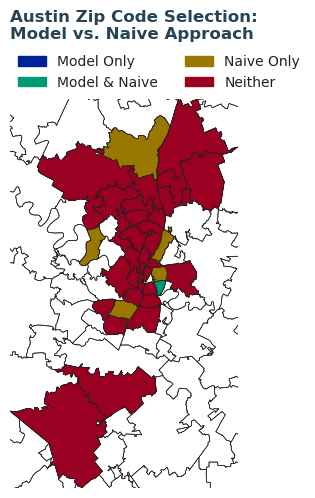

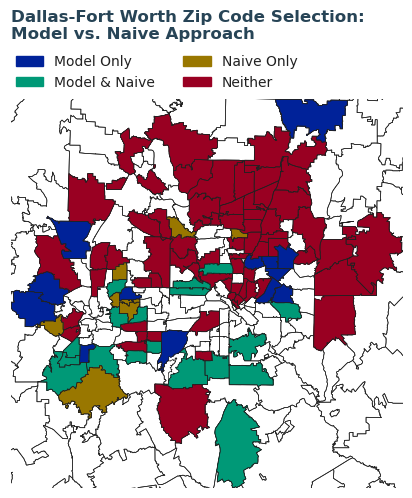

In [12]:
four_colors = ['#990022','#997700','#009977','#002299']
zips_code = [0,1,2,3]
color_mapping = dict(zip(zips_code,four_colors))

map_ = forecast
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():
    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
#                      column = graph_df["invest_rec_5_per"], 
                  color=graph_df["invest_rec_5_per"].map(color_mapping),
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro +' Zip Code Selection:\nModel vs. Naive Approach\n\n\n')
    # # legend
    acutal_patch = mpatches.Patch(color=four_colors[3], 
                               label='Model Only')
    lasso_patch = mpatches.Patch(color=four_colors[2], 
                               label='Model & Naive')
    rf_patch = mpatches.Patch(color=four_colors[1], 
                               label='Naive Only')
    xg_patch = mpatches.Patch(color=four_colors[0], 
                               label='Neither')
    plt.legend(handles=[acutal_patch,lasso_patch,rf_patch,xg_patch],
               loc='center left', 
               bbox_to_anchor=(-0.02, 1.07),frameon=False,ncol=2,
                    title = '')
    plt.show()

#### Forecasted growth

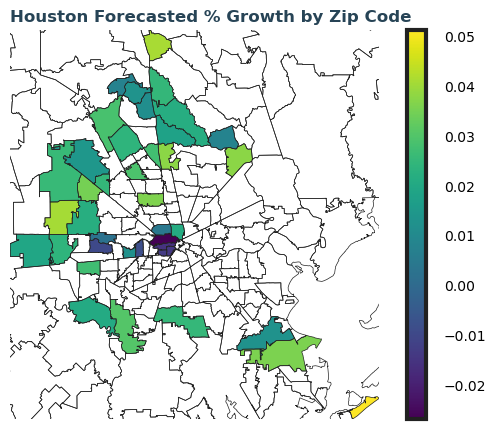

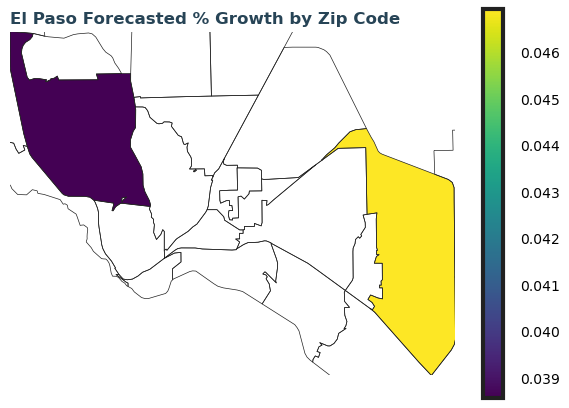

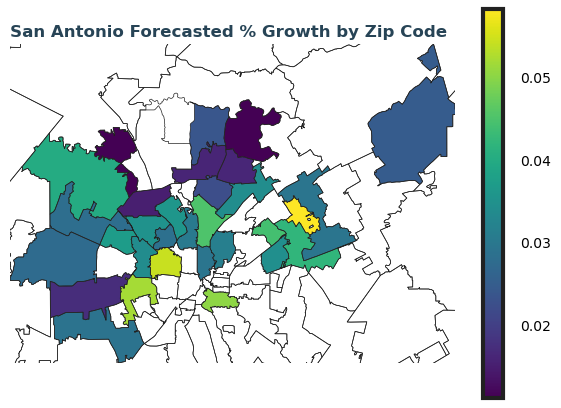

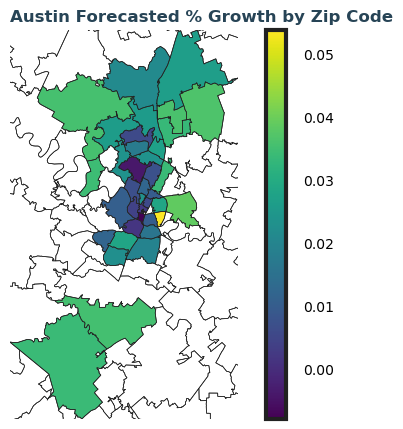

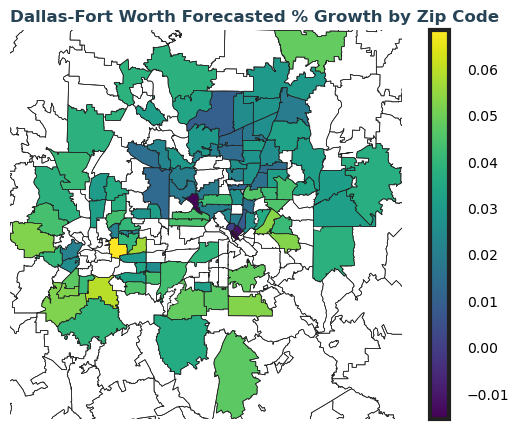

In [13]:

four_colors = ['#990022','#997700','#009977','#002299']
map_ = fore_pred_growth
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():
    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["mean_pred_growth"], 
#                   color=graph_df["invest_rec_5_per"].map(color_mapping),
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro +' Forecasted % Growth by Zip Code')
    plt.show()